In [1]:
!pip install opendatasets --upgrade --quiet

In [2]:
import opendatasets as od
dataset_url="https://www.kaggle.com/datasets/splcher/animefacedataset"
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: Navodit Sahai
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/splcher/animefacedataset


100%|██████████| 395M/395M [00:00<00:00, 505MB/s]


In [3]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [4]:
image_size=64
batch_size=128
stats=(0.5,0.5,0.5),(0.5,0.5,0.5)

In [5]:
transform = T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)
])

train_ds = ImageFolder("/content/animefacedataset/", transform=transform)

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Creating helper functions to denormalize the image tensors

In [6]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
def denorm(image_tensors):
  return image_tensors*stats[1][0]+stats[0][0]

In [8]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))


def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break


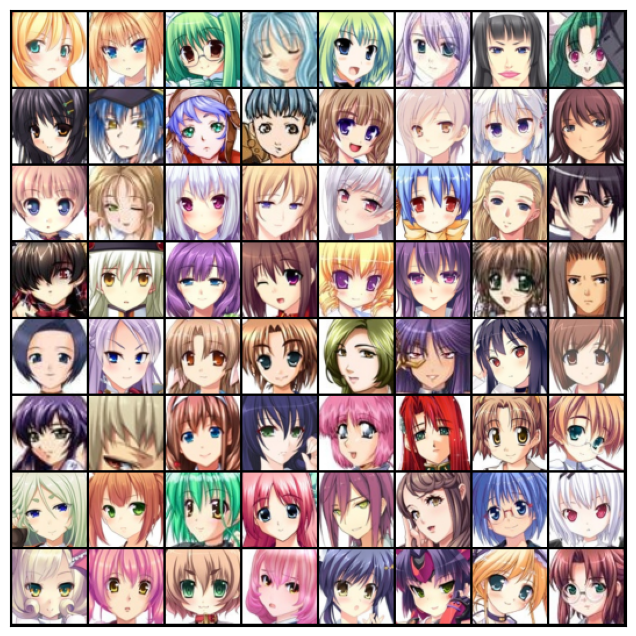

In [9]:
show_batch(train_dl)

In [10]:
import torch.nn as nn


In [87]:
discriminator=nn.Sequential(
    nn.Conv2d(3,64,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2,inplace=True),

    nn.Conv2d(64,128,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2,inplace=True),

    nn.Conv2d(128,256,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2,inplace=True),

    nn.Conv2d(256,512,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2,inplace=True),

    nn.Conv2d(512,1,kernel_size=4,stride=1,padding=0,bias=False),
    nn.Flatten(),

)

Generator

In [88]:
latent_size=128

In [89]:
generator=nn.Sequential(
    nn.ConvTranspose2d(128,512,kernel_size=4,stride=1,padding=0,bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),

    nn.ConvTranspose2d(512,256,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),

    nn.ConvTranspose2d(256,128,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),

    nn.ConvTranspose2d(128,64,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),

    nn.ConvTranspose2d(64,3,kernel_size=4,stride=2,padding=1,bias=False),
    nn.Tanh()
)

torch.Size([128, 3, 64, 64])


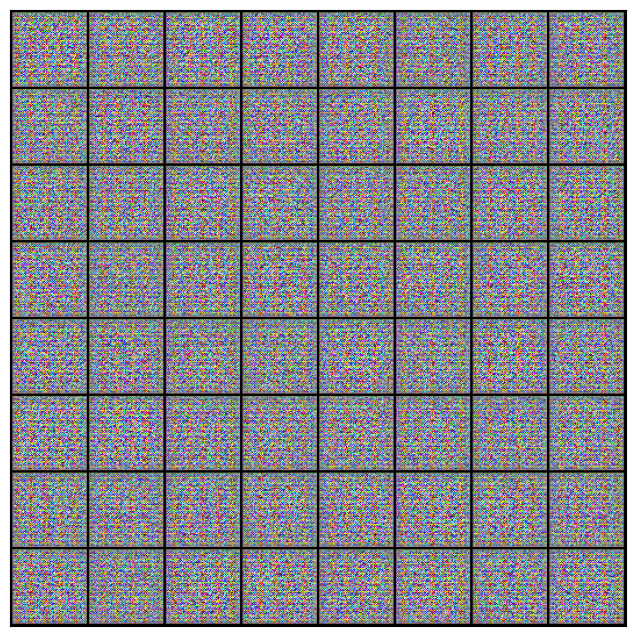

In [90]:
xb=torch.randn(batch_size,latent_size,1,1)#random latent tensors
fake_images=generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [91]:
def train_discriminator(real_images, opt_d, device):
  for param in discriminator.parameters():
      param.requires_grad = True
  for param in generator.parameters():
      param.requires_grad = False

  opt_d.zero_grad()

  # Real images
  real_pred = discriminator(real_images)
  real_targets = torch.ones(real_images.size(0), 1).to(device) * 0.9  # Label smoothing
  real_loss = F.binary_cross_entropy_with_logits(real_pred, real_targets)
  real_score = torch.sigmoid(real_pred).mean().item()  # Apply sigmoid for score

  # Fake images
  fake_latent = torch.randn(batch_size, latent_size, 1, 1).to(device)
  fake_images = generator(fake_latent).detach()
  fake_pred = discriminator(fake_images)
  fake_targets = torch.zeros(fake_images.size(0), 1).to(device)
  fake_loss = F.binary_cross_entropy_with_logits(fake_pred, fake_targets)  # Changed
  fake_score = torch.sigmoid(fake_pred).mean().item()  # Apply sigmoid for score

  loss = real_loss + fake_loss
  loss.backward()
  opt_d.step()
  return loss.item(), real_score, fake_score

In [100]:
def train_generator(opt_g, device):
  for param in discriminator.parameters():
        param.requires_grad = False
  for param in generator.parameters():
      param.requires_grad = True

  opt_g.zero_grad()
  fake_latent = torch.randn(batch_size, latent_size, 1, 1).to(device)
  fake_images = generator(fake_latent)
  target = torch.ones(batch_size, 1).to(device)
  pred = discriminator(fake_images)
  loss = F.binary_cross_entropy_with_logits(pred, target)
  loss.backward()
  opt_g.step()
  return loss.item()

In [93]:
import os
from torchvision.utils import save_image
sample_dir='generated'
os.makedirs(sample_dir,exist_ok=True)

In [94]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)

    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))


In [95]:
fixed_latent=torch.randn(64,latent_size,1,1)

In [96]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [97]:
def fit(epochs, lr, start_index=1):

    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    generator.to(device)
    discriminator.to(device)

    # Move fixed_latent to the device once
    global fixed_latent
    fixed_latent = fixed_latent.to(device)

    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):

        for real_images, _ in tqdm(train_dl):

            # Move data to GPU
            real_images = real_images.to(device)

            # Train Discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d, device)

            # Train Generator
            loss_g = train_generator(opt_g, device)

        # Store scalar values
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        print(f"Epoch [{epoch+1}/{epochs}] | "
              f"Loss_G: {loss_g:.4f} | "
              f"Loss_D: {loss_d:.4f} | "
              f"Real Score: {real_score:.4f} | "
              f"Fake Score: {fake_score:.4f}")

        # Save samples once per epoch
        save_samples(epoch + start_index, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores

In [98]:
lr=0.0002
epochs=15

In [99]:
history=fit(epochs,lr)

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [1/15] | Loss_G: 4.3118 | Loss_D: 0.4492 | Real Score: 0.7835 | Fake Score: 0.0072
Saving generated-images-0001.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [2/15] | Loss_G: 5.3713 | Loss_D: 0.6010 | Real Score: 0.8356 | Fake Score: 0.1722
Saving generated-images-0002.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [3/15] | Loss_G: 5.3461 | Loss_D: 0.5251 | Real Score: 0.8647 | Fake Score: 0.1177
Saving generated-images-0003.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [4/15] | Loss_G: 5.2199 | Loss_D: 0.4988 | Real Score: 0.8665 | Fake Score: 0.1139
Saving generated-images-0004.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [5/15] | Loss_G: 4.8349 | Loss_D: 0.4375 | Real Score: 0.8734 | Fake Score: 0.0635
Saving generated-images-0005.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [6/15] | Loss_G: 6.0824 | Loss_D: 0.8708 | Real Score: 0.9799 | Fake Score: 0.3095
Saving generated-images-0006.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [7/15] | Loss_G: 3.5557 | Loss_D: 0.5154 | Real Score: 0.7242 | Fake Score: 0.0067
Saving generated-images-0007.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [8/15] | Loss_G: 3.6510 | Loss_D: 0.4966 | Real Score: 0.7132 | Fake Score: 0.0214
Saving generated-images-0008.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [9/15] | Loss_G: 3.7175 | Loss_D: 0.4990 | Real Score: 0.6963 | Fake Score: 0.0116
Saving generated-images-0009.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [10/15] | Loss_G: 4.5183 | Loss_D: 0.4150 | Real Score: 0.9381 | Fake Score: 0.0511
Saving generated-images-0010.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [11/15] | Loss_G: 9.4868 | Loss_D: 1.5054 | Real Score: 0.9966 | Fake Score: 0.4847
Saving generated-images-0011.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [12/15] | Loss_G: 4.0997 | Loss_D: 0.4103 | Real Score: 0.8300 | Fake Score: 0.0285
Saving generated-images-0012.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [13/15] | Loss_G: 3.7983 | Loss_D: 0.4521 | Real Score: 0.7927 | Fake Score: 0.0538
Saving generated-images-0013.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [14/15] | Loss_G: 2.8397 | Loss_D: 0.4467 | Real Score: 0.7842 | Fake Score: 0.0458
Saving generated-images-0014.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [15/15] | Loss_G: 4.6689 | Loss_D: 0.5478 | Real Score: 0.9511 | Fake Score: 0.1512
Saving generated-images-0015.png


In [101]:
torch.save(generator.state_dict(), 'generator.pth')
torch.save(discriminator.state_dict(), 'discriminator.pth')
print("Models saved as generator.pth and discriminator.pth")

Models saved as generator.pth and discriminator.pth
